### Directory Checking

In [2]:
%cd /kaggle/input/plantdisease
!ls
%cd /kaggle/working
!ls

/kaggle/input/plantdisease
PlantVillage  plantvillage
/kaggle/working


### EfficientNet

- [efficientnet-torch](https://github.com/lukemelas/EfficientNet-PyTorch)
- About A PyTorch implementation of EfficientNet

In [3]:
# !git clone https://github.com/lukemelas/EfficientNet-PyTorch
# %cd ./EfficientNet-PyTorch
# !pip install -e .

### Import Packages

In [4]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import numpy as np
import random
import time
import copy

from sklearn.metrics import precision_score, recall_score

In [5]:
import torch

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

print(torch.cuda.is_available())

!nvidia-smi # gpu 확인

True
Thu May 30 23:08:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              26W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

### ImageFolder

- https://pytorch.org/docs/stable/torchvision/models.html
- Mean and std used in code are calculated based on millions of images.

In [6]:
batch_size = 64

data_path = '/kaggle/input/plantdisease/PlantVillage'
leaf_datasets = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

### Data split

- train and validation(80) / test(20)

In [7]:
random_seed = 33
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset = {}

train_idx, valtest_idx = train_test_split(list(range(len(leaf_datasets))), test_size=0.2, random_state=random_seed)
dataset['train'] = Subset(leaf_datasets, train_idx)
valtest          = Subset(leaf_datasets, valtest_idx)


val_idx, test_idx = train_test_split(list(range(len(valtest))), test_size=0.5, random_state=random_seed)
dataset['valid'] = Subset(valtest, val_idx)
dataset['test']  = Subset(valtest, test_idx)

In [8]:
print(len(dataset['train']))
print(len(dataset['valid']))

16510
2064


In [9]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset['train'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['valid'] = DataLoader(dataset['valid'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['test'] = DataLoader(dataset['test'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)


batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  test/valid : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 64,  test/valid : 258 / 33 / 33


### class distribution check

In [10]:
count = np.zeros(15)

for images, labels in dataloaders['train']:  
    for a in labels:
      count[a.numpy()] += 1

print(count)


v_count = np.zeros(15)

for images, labels in dataloaders['valid']:  
    for a in labels:
      v_count[a.numpy()] += 1

print(v_count)

[ 812. 1155.  773.  784.  127. 1717.  814. 1542.  788. 1421. 1359. 1119.
 2544.  294. 1261.]
[ 99. 159. 124.  93.  14. 217.  95. 182.  76. 155. 147. 157. 343.  43.
 160.]


torch.Size([3, 224, 224])


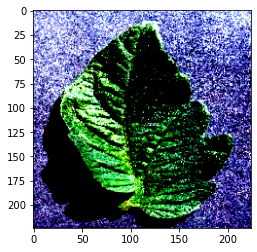

In [11]:
imgtest = None
for images, labels in dataloaders['train']:  
    imgtest = images[3]
    print(imgtest.shape)
    break

imgtest = imgtest.numpy()
imgtest = np.moveaxis(imgtest, 0, -1)
imshow(imgtest)

In [12]:
!pip install efficientnet_pytorch
%cd /kaggle/working/EfficientNet-PyTorch

from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=15)
model = EfficientNet.from_name('efficientnet-b0', num_classes=15)

for param in model.parameters():
    param.requires_grad = True

dev = torch.device("cuda") 

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=39e829309107f9ec45fa7705b0ef9e369a82cdd967555d5fd028a13c5d97ee0f
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
[Errno 2] No such file or directory: '/kaggle/working/EfficientNet-PyTorch'
/kaggle/working


In [13]:
model = model.to(dev)

optimizer = optim.SGD(model.parameters(), 
                         lr = 0.001,
                         momentum=0.9,
                         weight_decay=1e-3)

criterion = nn.CrossEntropyLoss()

## Training

- Train and validation is done in 1 epoch
- Trace train, val accuracy scores and losses
- Save the model which has the highest validation accuracy

- total number of train data = 12382
- train acc = corrects / 12382 * 100 = corrects * **0.008**
- total number of validation data = 4128
- val acc = corrects / 4128 * 100 = corrects * **0.0242**

In [14]:
num_epochs = 40
trn_loss_list, val_loss_list, trn_acc_list, val_acc_list = [], [], [], []
trn_precision_list, val_precision_list = [], []
trn_recall_list, val_recall_list = [], []
best_acc = 0.0

since = time.time()
best_model = copy.deepcopy(model.state_dict())


for epoch in range(num_epochs):    
    trn_loss, trn_corrects, val_loss, val_corrects = 0.0, 0, 0.0, 0
    trn_preds, trn_targets = [], []
    val_preds, val_targets = [], []
    
    model.train()
    for i, (data, target) in enumerate(dataloaders['train']):
        data, target = data.to(dev), target.to(dev)

        optimizer.zero_grad()
        output = model(data)                
    
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()  
        
        _, preds = torch.max(output, 1)
        trn_corrects += torch.sum(preds == target.data)
        trn_loss += loss.item()
        trn_preds.extend(preds.cpu().numpy())
        trn_targets.extend(target.cpu().numpy())

    trn_precision = precision_score(trn_targets, trn_preds, average='weighted')
    trn_recall = recall_score(trn_targets, trn_preds, average='weighted')
    
    model.eval()
    with torch.no_grad():
        for j, (val_data, val_target) in enumerate(dataloaders['valid']):
            val_data, val_target = val_data.to(dev), val_target.to(dev)
            
            val_output = model(val_data)
            v_loss = criterion(val_output, val_target)
            
            _, preds = torch.max(val_output, 1)
            val_corrects += torch.sum(preds == val_target.data)
            val_loss += v_loss.item()
            
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(val_target.cpu().numpy())

    val_precision = precision_score(val_targets, val_preds, average='weighted')
    val_recall = recall_score(val_targets, val_preds, average='weighted')
    
    trn_acc_list.append(trn_corrects * 0.008)
    val_acc_list.append(val_corrects * 0.0242)
    trn_loss_list.append(trn_loss/batch_num['train'])
    val_loss_list.append(val_loss/batch_num['valid'])
    trn_precision_list.append(trn_precision)
    trn_recall_list.append(trn_recall)
    val_precision_list.append(val_precision)
    val_recall_list.append(val_recall)

    time_elapsed = time.time() - since
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | {:.0f}m {:.0f}s elapsed".format(
                epoch+1, num_epochs, trn_loss / batch_num['train'], val_loss / batch_num['valid'], 
                time_elapsed // 60, time_elapsed % 60))
    
    print(f"Train Accuracy: {trn_corrects * 100.0 / len(dataloaders['train'].dataset):.4f} | "
          f"Train Precision: {trn_precision:.4f} | Train Recall: {trn_recall:.4f}")
    print(f"Validation Accuracy: {val_corrects * 100.0 / len(dataloaders['valid'].dataset):.4f} | "
          f"Validation Precision: {val_precision:.4f} | Validation Recall: {val_recall:.4f}")

    if val_corrects * 0.0242 > best_acc:
      best_acc = val_corrects * 0.0242
      best_model = copy.deepcopy(model.state_dict())
      print("best model updated-epoch: {} | val_accuracy: {:.4f}".format(epoch+1, best_acc))


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best valid Acc: %.1f' %(best_acc))

model.load_state_dict(best_model)
torch.save(model.state_dict(), '/kaggle/working/best_model.pt')
print("model saved")

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 1/40 | trn loss: 2.2842 | val loss: 2.6353 | 1m 24s elapsed
Train Accuracy: 25.0333 | Train Precision: 0.2094 | Train Recall: 0.2503
Validation Accuracy: 16.6182 | Validation Precision: 0.0276 | Validation Recall: 0.1662
best model updated-epoch: 1 | val_accuracy: 8.3006
epoch: 2/40 | trn loss: 1.7189 | val loss: 2.7397 | 2m 47s elapsed
Train Accuracy: 44.4518 | Train Precision: 0.3702 | Train Recall: 0.4445
Validation Accuracy: 21.8508 | Validation Precision: 0.1866 | Validation Recall: 0.2185
best model updated-epoch: 2 | val_accuracy: 10.9142
epoch: 3/40 | trn loss: 1.2891 | val loss: 1.2706 | 4m 10s elapsed
Train Accuracy: 58.0254 | Train Precision: 0.5412 | Train Recall: 0.5803
Validation Accuracy: 55.3779 | Validation Precision: 0.6291 | Validation Recall: 0.5538
best model updated-epoch: 3 | val_accuracy: 27.6606
epoch: 4/40 | trn loss: 0.9484 | val loss: 0.7214 | 5m 33s elapsed
Train Accuracy: 68.9461 | Train Precision: 0.6729 | Train Recall: 0.6895
Validation Accuracy: 

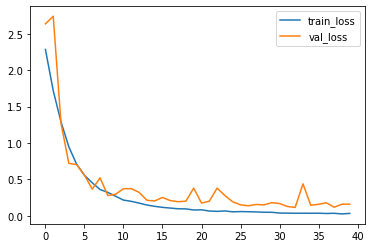

In [15]:
plt.plot(trn_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()

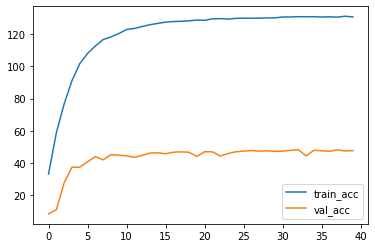

In [16]:
plt.plot(trn_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend()

In [17]:
best_model = EfficientNet.from_name('efficientnet-b0', num_classes=15)
best_model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))

best_model.to(dev)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [18]:
corrects = 0
total = 0

model.eval()
with torch.no_grad():
    for j, (data, target) in enumerate(dataloaders['test']):
        data, target = data.to(dev), target.to(dev)

        output = best_model(data)
        
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += len(preds)
        
print("{}/{} | test accuracy: {:.4f}".format(corrects, total, corrects/total))

1953/2064 | test accuracy: 0.9462
